In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
def one_hot_encode(y, num_classes):
    return np.eye(num_classes)[y]

In [18]:
# read mnist data
def read_mnist_images(filename):
    with open(filename, 'rb') as f:
        data = f.read()
        assert int.from_bytes(data[:4], byteorder='big') == 2051
        n_images = int.from_bytes(data[4:8], byteorder='big')
        n_rows = int.from_bytes(data[8:12], byteorder='big')
        n_cols = int.from_bytes(data[12:16], byteorder='big')
        images = np.frombuffer(data, dtype=np.uint8, offset=16).reshape(n_images, n_rows, n_cols)
        return images, n_images


def read_mnist_labels(filename):
    with open(filename, 'rb') as f:
        data = f.read()
        assert int.from_bytes(data[:4], byteorder='big') == 2049
        labels = np.frombuffer(data, dtype=np.uint8, offset=8)
        return labels


x, num_inputs = read_mnist_images('mnist/train-images.idx3-ubyte')
x = x.reshape((-1, 1, 28, 28))
x = x / 255.
y = one_hot_encode(read_mnist_labels('mnist/train-labels.idx1-ubyte'), 10)

In [109]:
kernels = np.random.rand(3, 1, 3, 3) - 0.5
kernels = np.array([[[
    [1, 1, 1], 
    [0, 0, 0], 
    [-1, -1, -1]]], [[[1, 1, 1], [0, 0, 0], [-1, -1, -1]]], [[[1, 1, 1], [0, 0, 0], [-1, -1, -1]]]])

conv = LayerConvolutional(3, 2, 1)
conv.forward(x[:5])


pre-relu shape:(5, 2, 28, 28)
postrelu shape: (5, 2, 28, 28)


(5, 2, 28, 28)

In [70]:
a = np.append(test, test2, axis=1)

In [72]:
print(a.shape)

(5, 2, 28, 28)


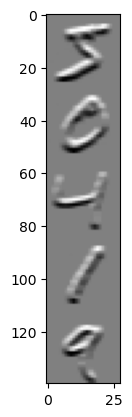

In [74]:
plt.imshow(test.reshape((-1, 28)), cmap='gray')

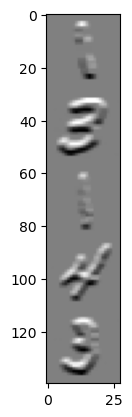

In [75]:
plt.imshow(test2.reshape((-1, 28)), cmap='gray')

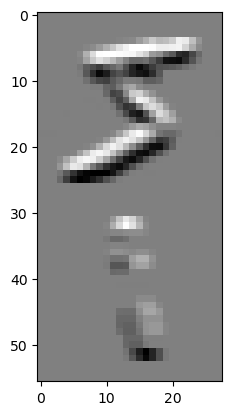

In [79]:
plt.imshow(a[0].reshape((-1, 28)), cmap='gray')

In [81]:
a[0].shape

(2, 28, 28)

In [63]:
class LayerDense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = np.random.rand(n_inputs, n_neurons) - 0.5
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.biases
        self.inputs = inputs


    def backward(self, d_values):
        self.dweights = np.dot(self.inputs.T, d_values) / len(self.inputs)
        self.dbiases = np.sum(d_values, axis=0, keepdims=True) / len(self.inputs)
        self.dinputs = np.dot(d_values, self.weights.T) / len(self.inputs)

In [108]:
class LayerConvolutional:
    def __init__(self, kernel_size, num_kernels, num_channels, relu=True):
        self.filters =  np.random.rand(num_kernels, num_channels, kernel_size, kernel_size) - 0.5
        self.biases = np.zeros(num_kernels)
        self.relu = relu
    
    def forward(self, inputs):
        self.inputs = inputs
        if self.filters.shape[1] != self.inputs.shape[1]:
            raise 'Error: number of filter and image channels does not match.'
        for kernel, bias in zip(self.filters, self.biases):
            if not hasattr(self, 'output'):
                self.output = sp.signal.convolve(self.inputs, [kernel], mode='same') + bias
            else:
                self.output = np.append(self.output, sp.signal.convolve(self.inputs, [kernel], mode='same') + bias, axis=1)
        if self.relu:
            self.output = np.maximum(self.output, 0)
    def backward(self, d_values):
        pass

In [ ]:
class LayerMaxPooling:
    def __init__(self, kernel_size):
        self.kernel_size = kernel_size
    
    def forward(self):
        pass
    
    def backward(self):
        pass

In [6]:
class ActivationReLU:
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)
        self.inputs = inputs

    def backward(self, d_values):
        self.dinputs = d_values.copy()
        self.dinputs[self.inputs <= 0] = 0

In [7]:
class ActivationSoftmaxLossCategoricalCrossentropy:
    def forward(self, inputs, correct_labels):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True)) # -np.max(...) for numerical stability with big number
        self.output = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        predictions = np.clip(self.output, 1e-7, 1 - 1e-7)
        loss = np.sum(-np.log(predictions) * correct_labels)
        return loss

    def backward(self, dvalues, correct_labels):
        self.dinputs = dvalues - correct_labels

In [8]:
class OptimizerSGD:
    def __init__(self, learning_rate=1.0):
        self.learning_rate = learning_rate

    def update_params(self, layer):
        
        weight_updates = -self.learning_rate * layer.dweights
        bias_updates = -self.learning_rate * layer.dbiases
        
        layer.weights += weight_updates
        layer.biases += bias_updates


In [9]:
class Network:
    def __init__(self, layers=[], optimizer=None):
        self.layers = layers
        self.optimizer = optimizer
    
    def add(self, layer):
        self.layers.append(layer)
    
    def forward_propagation(self, x_batch, y_batch):
        prev_layer = None
        for layer in self.layers:
            if isinstance(layer, LayerDense):
                layer_input = x_batch if prev_layer is None else prev_layer.output
                layer.forward(layer_input)
            elif isinstance(layer, ActivationReLU):
                layer.forward(prev_layer.output)
            elif isinstance(layer, ActivationSoftmaxLossCategoricalCrossentropy):
                loss = layer.forward(prev_layer.output, y_batch)
            prev_layer = layer
        return loss
    
    def back_propagation(self, y_batch):
        layers_reversed = self.layers[::-1]
        prev_layer = None
        for layer in layers_reversed:
            if isinstance(layer, ActivationSoftmaxLossCategoricalCrossentropy):
                layer.backward(layer.output, y_batch)
            elif isinstance(layer, LayerDense):
                layer.backward(prev_layer.dinputs)
            elif isinstance(layer, ActivationReLU):
                layer.backward(prev_layer.dinputs)
            prev_layer = layer
        for layer in self.layers:
            if isinstance(layer, LayerDense):
                self.optimizer.update_params(layer)
    
    def train(self, x, y, epochs, batch_size):
        for i in range(epochs):
            for j in range(0, len(x), batch_size):
                x_batch = x[j:j+batch_size]
                y_batch = y[j:j+batch_size]
                loss = self.forward_propagation(x_batch, y_batch)
                self.back_propagation(y_batch)
                predictions = np.argmax(self.layers[-1].output, axis=1)
                accuracy = np.mean(predictions == np.argmax(y_batch, axis=1))
            print(f'epoch: {i}, ' + f'acc: {accuracy:.3f}, ' + f'loss: {loss:.3f}')

In [9]:
network = Network([
    LayerDense(784, 10),
    ActivationReLU(),
    LayerDense(10, 10),
    ActivationSoftmaxLossCategoricalCrossentropy()
], OptimizerSGD())

epochs = 100
batch_size = 60

network.train(x, y, epochs, batch_size)

epoch: 0, acc: 0.850, loss: 22.761
epoch: 1, acc: 0.900, loss: 16.954
epoch: 2, acc: 0.933, loss: 14.287
epoch: 3, acc: 0.933, loss: 12.722
epoch: 4, acc: 0.933, loss: 11.038
epoch: 5, acc: 0.933, loss: 9.593
epoch: 6, acc: 0.967, loss: 8.075
epoch: 7, acc: 0.983, loss: 7.208
epoch: 8, acc: 0.983, loss: 6.795
epoch: 9, acc: 0.983, loss: 6.644
epoch: 10, acc: 0.983, loss: 6.723
epoch: 11, acc: 0.967, loss: 6.794
epoch: 12, acc: 0.967, loss: 6.826
epoch: 13, acc: 0.967, loss: 7.018
epoch: 14, acc: 0.967, loss: 7.150
epoch: 15, acc: 0.950, loss: 7.320
epoch: 16, acc: 0.950, loss: 7.388
epoch: 17, acc: 0.950, loss: 7.435
epoch: 18, acc: 0.933, loss: 7.360
epoch: 19, acc: 0.933, loss: 7.373
epoch: 20, acc: 0.950, loss: 7.370
epoch: 21, acc: 0.967, loss: 7.266
epoch: 22, acc: 0.967, loss: 7.148
epoch: 23, acc: 0.967, loss: 7.019
epoch: 24, acc: 0.983, loss: 6.901
epoch: 25, acc: 0.983, loss: 6.767
epoch: 26, acc: 0.983, loss: 6.684
epoch: 27, acc: 0.983, loss: 6.504
epoch: 28, acc: 0.983, lo

KeyboardInterrupt: 

In [13]:
test_sample_num = 9894
x_test, num_inputs = read_mnist_images('mnist/t10k-images.idx3-ubyte')
x_test_flat = x_test.reshape(-1, 784) / 255.
y_test = one_hot_encode(read_mnist_labels('mnist/t10k-labels.idx1-ubyte'), 10)
network.forward_propagation(x_test_flat, y_test)
print(np.argmax(network.layers[-1].output[test_sample_num]))
print(np.argmax(y_test[test_sample_num]))


7
7


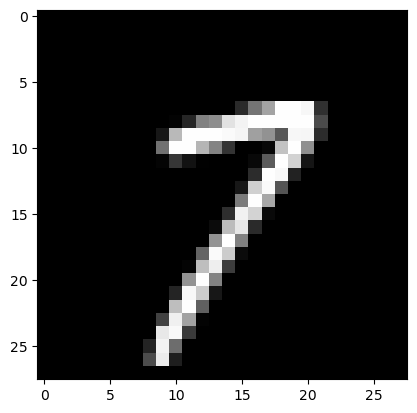

In [12]:
plt.imshow(x_test[9894], cmap='gray')

In [10]:
clothes, num_inputs = read_mnist_images('fashion_mnist/train-images-idx3-ubyte')

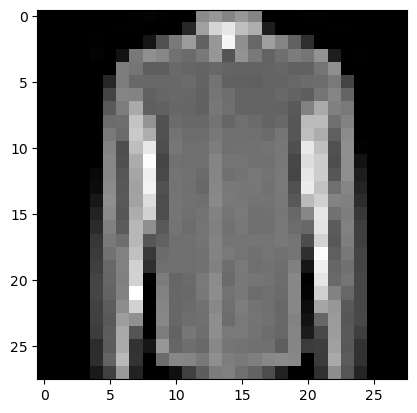

In [16]:
plt.imshow(clothes[95], cmap='gray')